# 通过激发态 VQE 探测多体定位

## 概述

本教程介绍了一种通过激发态 VQE 探测多体定位 (MBL) 的新方法。 这里考虑的托管 MBL 转换的模型是交互的 Aubry-Andr$\acute{e}$ 模型，其内容如下：
$$
H=\sum_{i}(\sigma^{x}_{i}\sigma^{x}_{i+1}+\sigma^{y}_{i}\sigma^{y}_{i+1} +V_{0}\sigma_{i}^{z} \sigma_{i+1}^{z} ) \\
+W_{0} \sum_{i=1}^L \cos(2 \pi \eta i+\phi) \sigma_{i}^{z},
$$
其中 $\sigma^{x,y,z}_{i}$ 是第 $i$ 个量子比特的泡利矩阵，$L$ 是总量子比特数，$V_{0}$ 是 $zz$ 相互作用强度，$W$ 是准周期（QP）势的强度，$\phi$ 是余弦势的相位。 我们设置 $V_{0}=0.5$ 和 $\eta=(\sqrt{5}-1)/2$。 当$W$ 很大时，系统进入MBL 阶段并表现出奇异的行为，例如高激发态的“面积定律”纠缠。

## 设置

In [1]:
import time
import numpy as np
import tensorflow as tf
import tensorcircuit as tc

您可以在 ``TensorCircuit`` 中轻松定义不同的门。

In [2]:
tc.set_backend("tensorflow")
tc.set_dtype("complex128")
dtype = np.complex128

ii = tc.gates._ii_matrix
xx = tc.gates._xx_matrix
yy = tc.gates._yy_matrix
zz = tc.gates._zz_matrix

注意：本教程中的实现固定在 TensorFlow 后端。可以无缝自由地使用 `TensorCircuit` 的 API 和 `TensorFlow` 的 API ，自动微分和即时编译不受影响。

### 参数

In [3]:
L = 4
V0 = 0.5
W0 = [1.0, 10.0]  # W0=1.0：热相； W0=10.0：MBL 阶段
η = (np.sqrt(5) - 1) / 2
ϕ = 0.1

num_trial = 5  # 独立试验次数
depth = 1  # PQC的深度
θ0 = np.pi / 5.0  # 输入状态的旋转角度

### 构建电路

激发态 VQE 和本征态见证测量的电路结构。 这里 $U_{0}(\theta)= \rm{exp}(\frac{i\theta}{2}(\sigma^{x} \otimes \sigma^{x} + \sigma^{y} \ 有时\sigma^{y}))$。

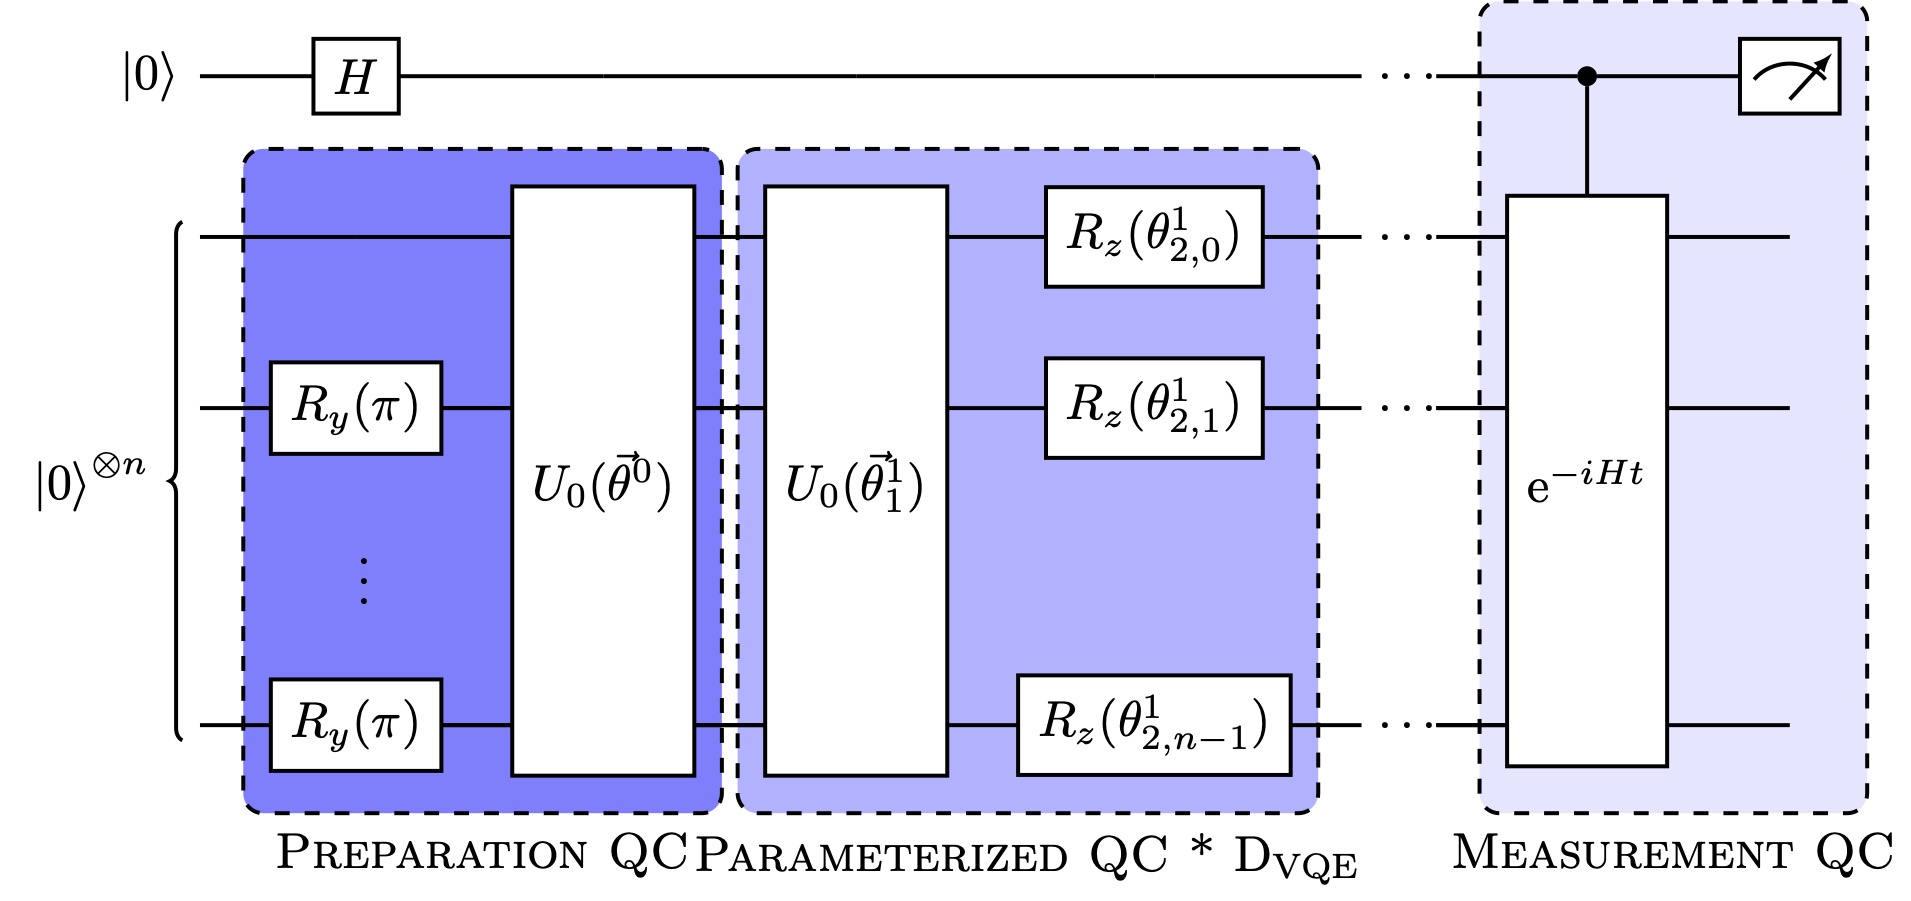

In [4]:
@tf.function
def get_ρ_circuit(v, epochs=2):
    c = tc.DMCircuit(L)

    ### 第一部分：输入态准备量子电路
    ### 从初始状态 |0000...> 准备一个反铁磁 (AF) 状态 (|0101...>)
    ### 由于 U(1) 对称性，系统将停留在 Mz=0 扇区
    for i in range(L):
        if i % 2 == 1:
            c.ry(i, theta=tf.cast(np.pi, dtype=dtype))

    ###        准备输入态
    for i in range(L):
        c.any(
            i,
            (i + 1) % L,
            unitary=0.5 * tf.math.cos(tf.cast(θ0, dtype=dtype)) * (ii - zz)
            + 0.5 * (ii + zz)
            + 0.5 * tc.backend.i() * tf.math.sin(tf.cast(θ0, dtype=dtype)) * (xx + yy),
        )  ### U_{0}(θ)
    ### 第二部分：参数化量子电路（PQC）：基于梯度下降优化参数
    for epoch in range(epochs):
        for i in range(L):
            c.any(
                i,
                (i + 1) % L,
                unitary=0.5
                * tf.math.cos(tf.cast(v[2 * epoch, i], dtype=dtype))
                * (ii - zz)
                + 0.5 * (ii + zz)
                + 0.5
                * tc.backend.i()
                * tf.math.sin(tf.cast(v[2 * epoch, i], dtype=dtype))
                * (xx + yy),
            )  ### U_{0}(θ)

        for i in range(L):
            c.rz(i, theta=tf.cast(v[2 * epoch + 1, i], dtype=dtype))
    ρ = c.densitymatrix()
    return ρ

### 构造哈密顿量

In [5]:
def get_hamiltonian(W0):
    h = []
    w = []
    ###XX
    for i in range(L):
        h.append([])
        w.append(1.0)
        for j in range(L):
            if j == (i + 1) % L or j == i:
                h[i].append(1)
            else:
                h[i].append(0)
    ###YY
    for i in range(L):
        h.append([])
        w.append(1.0)
        for j in range(L):
            if j == (i + 1) % L or j == i:
                h[i + L].append(2)
            else:
                h[i + L].append(0)
    ###ZZ
    for i in range(L):
        h.append([])
        w.append(V0)
        for j in range(L):
            if j == (i + 1) % L or j == i:
                h[i + 2 * L].append(3)
            else:
                h[i + 2 * L].append(0)
    ###potential
    for i in range(L):
        h.append([])
        w.append(W0 * np.cos(2 * np.pi * η * i + ϕ))
        for j in range(L):
            if j == i:
                h[i + 3 * L].append(3)
            else:
                h[i + 3 * L].append(0)

    hamiltonian = tc.quantum.PauliStringSum2Dense(
        tf.constant(h, dtype=tf.complex128), tf.constant(w, dtype=tf.complex128)
    )
    return hamiltonian

### 损失函数

这里使用的损失函数是本征态消失的能量方差：
$$
C(\theta) = \langle H^{2} \rangle - \langle H \rangle ^2 
$$

In [6]:
@tf.function
def variance_loss(hamiltonian, v, epochs=2):
    with tf.GradientTape() as tape:
        tape.watch(v)
        ρ = get_ρ_circuit(v, epochs)
        hexp = tf.linalg.trace(ρ @ hamiltonian)
        loss = tf.linalg.trace(ρ @ hamiltonian @ hamiltonian) - hexp ** 2
        loss = tf.math.real(loss)
    gr = tape.gradient(loss, v)
    return loss, gr, ρ

### 本征证人

在激发态 VQE 下，输出态会收敛到一些高激发态，MBL 相具有更高的本征态见证。

In [7]:
@tf.function
def get_eigenstate_witness(ρ, hamiltonian, evolution_time):
    evolution_p = tf.linalg.expm(
        tc.backend.i() * tf.cast(hamiltonian, dtype=dtype) * evolution_time
    )
    evolution_m = tf.linalg.expm(
        tc.backend.i() * tf.cast(hamiltonian, dtype=dtype) * (-evolution_time)
    )

    ρ_00 = tf.linalg.trace(ρ)
    ρ_01 = tf.linalg.trace(ρ @ evolution_p)
    ρ_10 = tf.linalg.trace(evolution_m @ ρ)
    ρ_11 = tf.linalg.trace(evolution_m @ ρ @ evolution_p)

    ρ_cq_up = tf.stack([ρ_00, ρ_01], axis=0)
    ρ_cq_dn = tf.stack([ρ_10, ρ_11], axis=0)
    ρ_cq = 0.5 * tf.stack([ρ_cq_up, ρ_cq_dn], axis=1)
    r = tf.linalg.trace(ρ_cq @ ρ_cq)
    return tf.math.real(r)

In [8]:
def opt_main(hamiltonian, epochs=2, maxiter=200):
    v = tf.Variable(
        initial_value=tf.random.normal(
            shape=[2 * epochs, L], mean=0.0, stddev=0.03, dtype=tf.float64
        )
    )  # initialize parameters
    opt = tf.keras.optimizers.Adam(learning_rate=0.02)
    print("loop begins")
    for i in range(maxiter):
        loss, gr, ρ = variance_loss(hamiltonian, v.value(), epochs)
        opt.apply_gradients([(tf.math.real(gr), v)])
        if i == maxiter - 1:
            print(loss.numpy())
    return ρ

In [9]:
start = time.time()
ρ_list = []
r_list = []
for i in range(len(W0)):
    hamiltonian = get_hamiltonian(W0[i])
    evolution_time = 10.0 / W0[i]
    ρ_list.append([])
    r_list.append([])
    for j in range(num_trial):
        ρ = opt_main(hamiltonian, depth)
        ρ_list[i].append(ρ)
        r = get_eigenstate_witness(ρ, hamiltonian, evolution_time)
        r_list[i].append(r)
endtime = time.time()
print("Run time = ", endtime - start)
print(
    "Eigenstate Witness:",
    np.mean(r_list[0]),
    "(Thermal Phase);",
    np.mean(r_list[1]),
    "(MBL Phase)",
)

loop begins
0.18502121452649556
loop begins
0.3647578794270281
loop begins
1.1563841018010805
loop begins
1.1626719640361998
loop begins
0.20636721189392704
loop begins
0.40186462162307635
loop begins
0.39881574091884886
loop begins
0.41128232341327475
loop begins
0.4055560658837294
loop begins
0.4046518612466343
Run time =  16.519852876663208
Eigenstate Witness: 0.8140801354126028 (Thermal Phase); 0.9994227942365521 (MBL Phase)


## 研究项目

参考文献: https://arxiv.org/pdf/2111.13719.pdf.